In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Number of samples
n_samples = 10000000

# Exogenous noise variables
U1 = np.random.normal(50, 10, n_samples)  # Noise for Age
U2 = np.random.normal(0, 1, n_samples)  # Noise for PreTreatmentHealthScore
U3 = np.random.uniform(0, 1, n_samples)  # Noise for Treatment
U4 = np.random.normal(0, 5, n_samples)  # Noise for RecoveryTime

# SCM equations
def f1(u1):
    return u1  # Age is directly derived from exogenous noise U1

def f2(age, u2):
    return age/10 + u2  # PreTreatmentHealthScore is a function of Age

def f3(pretreatment_health_score, u3):
    # Treatment is more likely if PreTreatmentHealthScore is lower
    return (pretreatment_health_score < 6) & (u3 < 0.8)

def f4(pretreatment_health_score, treatment, u4):
    # RecoveryTime is influenced by PreTreatmentHealthScore and Treatment
    base_recovery_time = 30 - 3 * pretreatment_health_score
    treatment_effect = np.where(treatment, -5, 0) # Treatment reduces RecoveryTime by 5
    return base_recovery_time + treatment_effect + u4

# Generate observational data
Age = f1(U1)
PreTreatmentHealthScore = f2(Age, U2)
Treatment = f3(PreTreatmentHealthScore, U3)
RecoveryTime = f4(PreTreatmentHealthScore, Treatment, U4)

# Interventional Distribution: Simulate an intervention where all individuals receive treatment
Treatment_intervention = np.ones(n_samples, dtype=bool)
RecoveryTime_intervention = f4(PreTreatmentHealthScore, Treatment_intervention, U4)

# Counterfactual: What would the RecoveryTime be for those who didn't receive treatment, had they received it?
Treatment_counterfactual = np.ones(np.sum(Treatment == 0), dtype=bool)
print(Treatment_counterfactual)
print(Treatment_counterfactual.shape)
noise_for_counterfactual = U4[Treatment == 0]
pre_treatment_health_scores_for_counterfactual = PreTreatmentHealthScore[Treatment == 0]
RecoveryTime_counterfactual = f4(pre_treatment_health_scores_for_counterfactual, Treatment_counterfactual, noise_for_counterfactual)

[ True  True  True ...  True  True  True]
(3917067,)


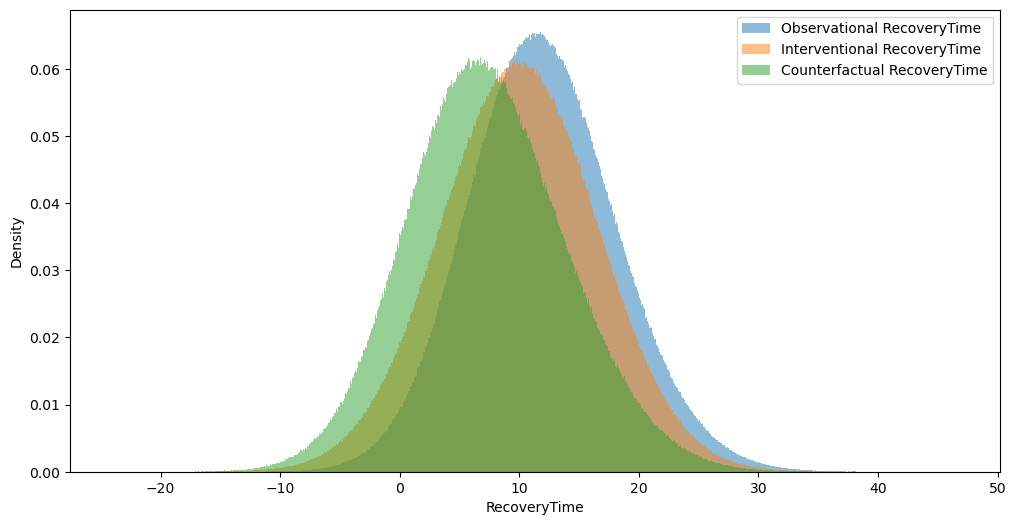

In [16]:
plt.figure(figsize=(12, 6))

# Density instead of frequency
plt.hist(RecoveryTime, bins=1000, alpha=0.5, label="Observational RecoveryTime", density=True)
plt.hist(RecoveryTime_intervention, bins=1000, alpha=0.5, label="Interventional RecoveryTime", density=True)
plt.hist(RecoveryTime_counterfactual, bins=1000, alpha=0.5, label="Counterfactual RecoveryTime", density=True)

plt.xlabel("RecoveryTime")
plt.ylabel("Density")
plt.legend()
plt.show()

# Abduction

In the abduction step, we infer the state of the world, the exogenous noise $\boldsymbol{\epsilon} = (U_1, U_2, U_3, U_4)$, given the observed data $(\text{Age}, \text{PreTreatmentHealthScore}, \text{Treatment}, \text{RecoveryTime})$.  Here, the inferred state of the world is already given as $(U_1, U_2, U_3, U_4)$ for each sample, as these are the exogenous noise variables we've sampled. Formally, 

$$
P_{\mathfrak{G}}(\boldsymbol{\epsilon} \mid \mathbf{x})=P_{\mathfrak{G}}\left(U_1, U_2, U_3, U_4 \mid \text { Age, PreTreatmentHealthScore, Treatment, RecoveryTime }\right)
$$

# Action

In this step, we are simulating an intervention, specifically setting the Treatment variable to 1 for all samples. The modified structural causal model is denoted by $\widetilde{\mathfrak{G}}$.

Formally, this corresponds to:
$$
\widetilde{\mathfrak{G}}=\mathfrak{G}_{\mathbf{x} ; \mathrm{do}(\text { Treatment:=1) }}=\left(\widetilde{\mathbf{S}}, P_{\mathfrak{G}}(\boldsymbol{\epsilon} \mid \mathbf{x})\right)
$$
intervention.

# Prediction

Finally, we compute the counterfactual distribution for RecoveryTime had everyone received the treatment.

Formally, we compute:
$$
P_{\widetilde{G}}(\text { RecoveryTime })=P_{\widetilde{G}}\left(\mathrm{f} 4\left(\text { PreTreatmentHealthScore, } 1, U_4\right)\right)
$$
This gives us the counterfactual distribution of RecoveryTime, assuming all individuals received treatment, with the state of the world remaining consistent with the original observations.